Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3676.015, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3688.335, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3681.376, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3675.192, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3687.233, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3677.009, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3676.837, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3676.977, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3675.459, Time=0.06 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3678.831, Time=0.31 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3686.235, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3674.579, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3677.097, Time=0.06 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3676.080, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0

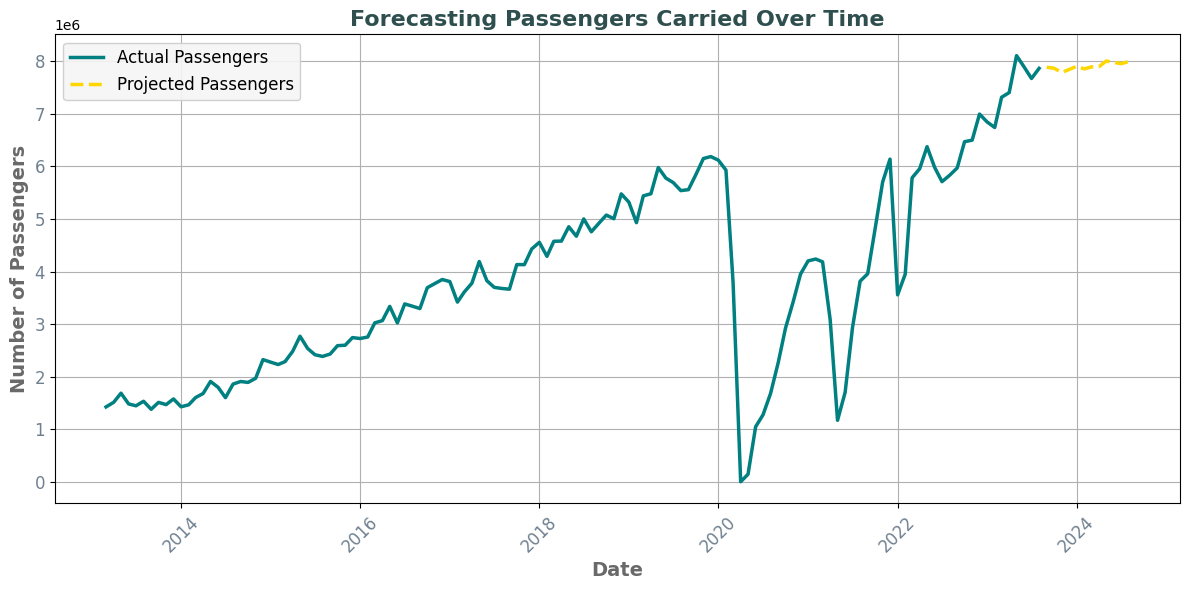

In [7]:
# part - a

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

def load_and_prepare_data(filepath, columns_of_interest):
    data = pd.read_csv(filepath)
    data.columns = data.columns.str.strip()
    data['MONTH'] = data['MONTH'].str.strip()
    for col in columns_of_interest:
        data[col] = pd.to_numeric(data[col].replace({",": ""}, regex=True), errors='coerce')
    data.fillna(0, inplace=True)
    month_mapping = {
        'JAN': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'APR': 'Apr', 'MAY': 'May',
        'JUN': 'Jun', 'JUL': 'Jul', 'AUG': 'Aug', 'SEP': 'Sep',
        'OCT': 'Oct', 'NOV': 'Nov', 'DEC': 'Dec'
    }
    data['MONTH'] = data['MONTH'].str[:3].str.upper().map(month_mapping)
    data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + "-" + data['MONTH'], format="%Y-%b")
    data.set_index('DATE', inplace=True)
    data.index = data.index.to_period("M")
    data.sort_index(inplace=True)
    return data

def add_lagged_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['PASSENGERS CARRIED'].shift(lag)
    return data

def fit_sarima_model(training_data):
    arima_model = auto_arima(
        training_data,
        seasonal=True,
        m=12,
        stepwise=True,
        trace=True,
        suppress_warnings=True,
        start_p=1,
        start_q=1,
        max_p=5,
        max_d=2,
        max_q=5,
        max_P=3,
        max_D=1,
        max_Q=3,
        information_criterion='aic'
    )
    sarima_model = SARIMAX(training_data, order=arima_model.order, seasonal_order=arima_model.seasonal_order)
    sarima_result = sarima_model.fit(disp=False)
    return sarima_result

if __name__ == "__main__":
    filepath = "AirtrafficA4.csv"
    columns_of_interest = [
        "TOTAL DEPARTURES", "HOURS FLOWN", "KILOMETRE FLOWN",
        "PASSENGERS CARRIED", "AVAILABLE SEAT KILOMETRE (IN THOUSAND)",
        "FREIGHT CARRIED (IN TONNE)", "MAIL CARRIED (IN TONNE)"
    ]

    data = load_and_prepare_data(filepath, columns_of_interest)
    lags = [1, 2]
    data = add_lagged_features(data, lags)
    data.dropna(inplace=True)
    npassengers = data['PASSENGERS CARRIED']
    ntraining = npassengers.loc[:'2023-08']
    sarima_result = fit_sarima_model(ntraining)
    nforecasted = 12
    forecast = sarima_result.get_forecast(steps=nforecasted)
    forecasted_values = forecast.predicted_mean
    forecasted_values.index = pd.period_range(start="2023-09", periods=nforecasted, freq="M")
    forecast_df = pd.DataFrame({
        'YEAR_MONTH': forecasted_values.index.strftime('%Y %b').str.upper(),
        'PASSENGERS CARRIED': np.round(forecasted_values.clip(lower=0)).astype(int)
    })
    forecast_df.to_csv('Q2a.csv', index=False)
    last_known_data = npassengers.loc['2023-01':'2023-08']
    predictions = sarima_result.predict(start=last_known_data.index[0], end=last_known_data.index[-1])
    mape = mean_absolute_percentage_error(last_known_data, predictions)
    print(f'MAPE for training data: {mape:.2%}')
    plt.figure(figsize=(12, 6))
    plt.plot(ntraining.index.to_timestamp(), ntraining, label='Actual Passengers', color='teal', linewidth=2.5)
    plt.plot(forecasted_values.index.to_timestamp(), forecasted_values, label='Projected Passengers', color='gold', linestyle='--', linewidth=2.5)
    plt.title('Forecasting Passengers Carried Over Time', fontsize=16, fontweight='bold', color='darkslategray')
    plt.xlabel('Date', fontsize=14, fontweight='bold', color='dimgray')
    plt.ylabel('Number of Passengers', fontsize=14, fontweight='bold', color='dimgray')
    plt.xticks(rotation=45, fontsize=12, color='slategray')
    plt.yticks(fontsize=12, color='slategray')
    legend = plt.legend(loc='upper left', fontsize=12)
    frame = legend.get_frame()
    frame.set_facecolor('whitesmoke')
    frame.set_alpha(0.9)
    plt.grid()
    plt.tight_layout()
    plt.savefig('Q2a.png', dpi=300)
    plt.show()
